<center><h1>Stack Overflow Search Engine</h1></center>

In [0]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)
!pip install normalise

import nltk
nltk.download('brown')
nltk.download('names')
nltk.download('stopwords')

In [0]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import multiprocessing as mp
import heapq
from wordcloud import WordCloud
import gensim
from gensim.models.word2vec import Word2Vec

from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

<h1>Mounting the Drive </h1>

In [0]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [0]:
currentDirectory = "/content/drive/My Drive/pcase_study_1/"
dataDirectory = currentDirectory + "data/"
modelsDirectory = currentDirectory + "models/"

#<h1>1. Data Tranformation</h1>

<h2>1.1 Loading the data</h2>

In [0]:
data = pd.read_csv(dataDirectory + 'data.csv')

In [0]:
print("Number of records in the data: ",data.shape[0])
print("Number of Columns in the data: ",data.shape[1])

Number of records in the data:  1793879
Number of Columns in the data:  6


In [0]:
data.head(3)

,id,title,body,tags,answers,score
0,6842245,converting date time to 24 hour format,<p>The time I get from the server is like <co...,java|datetime,<p>Try this:</p>\n\n<pre><code>String dateStr ...,112
1,1205375,Filter by property,<p>Is it possible to filter a Django queryset ...,python|django|orm,<p>Nope. Django filters operate at the databa...,66
2,1927544,"""For"" loop first iteration",<p>I would like to inquire if there is an eleg...,python|algorithm|iteration,<p>Something like this should work.</p>\n\n<pr...,61


<h2>1.2 Data aggregation</h2>

<p>As we know some questions might have more than one Answer in the Stack Overflow,So we can group Questions(by Id) and Concate all the answers</p>

In [0]:
#https://stackoverflow.com/questions/47600818/python-pandas-groupby-sum-and-concatenate-strings

aggregations = {'answers': lambda x: "\n".join(x),'score': 'sum'}
data_agg = pd.DataFrame(data.groupby(['id','title', 'body','tags'],as_index=False).agg(aggregations))

In [0]:
print("Number of records in the data after aggregation: ",data_agg.shape[0])
print("Number of Columns in the data after aggregation: ",data_agg.shape[1])

Number of records in the data after aggregation:  1032990
Number of Columns in the data after aggregation:  6


In [0]:
data_agg.head(2)

,id,title,body,tags,answers,score
0,123,Java lib or app to convert CSV to XML file?,<p>Is there an existing application or library...,java|xml|csv|data-conversion,<p>Jackson processor family has backends for m...,260
1,126,How would you access Object properties from wi...,"<p>What is the ""purist"" or ""correct"" way to ac...",java|php|oop|theory,<p>If I won't edit the property I'll use a <co...,246


#<h1>2. Data Preprocessing</h1>

<h2>2.1 Missing Values</h2>

<p>There are no missing values in the corpus.</p>

In [0]:
#https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
data_agg.isnull().values.any()

False

In [0]:
data_agg.isna().sum()

id         0
title      0
body       0
tags       0
answers    0
score      0
dtype: int64

<h2>2.2 Duplication removal</h2>

<p>There are no duplications with title,body and answers combination.but we have some duplicates with title and body combinations,so answers for these are different so will keep as it is.</p>

In [0]:
#https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
data_agg[data_agg[['title','body','answers']].duplicated()]

,id,title,body,tags,answers,score


In [0]:
data_agg[data_agg[['title','body']].duplicated()]

,id,title,body,tags,answers,score
13416,852690,Reverse proxy capable pure python webserver?,<p>I am looking for a pure python based web se...,python|proxy|webserver|reverse,"<p>Have a look at <a href=""http://twistedmatri...",3
283011,13570366,Using Skue or similar frameworks to build REST...,"<p>Searching for ways to build REST APIs, I fo...",google-app-engine|rest|python-2.7|google-cloud...,<p>I'm the author of Skuë. Skuë means <strong...,4
539432,27979443,working of ndim in numpy,<pre><code>import numpy as np\n&gt;&gt;&gt; a=...,python|numpy,"<p>As the <a href=""http://docs.scipy.org/doc/n...",2


<h2>2.3 Text Pre-processing </h2>

<p>we will be performing following pre-process steps
<ul>
<li>Html tags removal</li>
<li>Url's removal</li>
<li>Decontraction of the text</li>
<li>Text normalization</li>
<li>Punctuation removal</li>
<li>Stop words removal</li>
</p>

In [0]:
#https://www.kaggle.com/balatmak/text-preprocessing-steps-and-universal-pipeline
import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
from nltk.corpus import stopwords

nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Html tags removal
            2. Url's removal
            3. Decontraction of the text
            4. Text normalization
            5. Punctuation removal
            6. Stop words removal
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, column,*_):
        """
        this method will be used in pre-processing which handle multi-processing
        """
        X_copy = X
        self.column = column

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores * 2
        elif self.n_jobs <= 0:
            return X_copy[column].apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy[column], partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        X_copy["processed_"+column] =  data

        return X_copy

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        """
        this method performs below tasks
        1. Html tags removal
        2. Url's removal
        3. Decontraction of the text
        4. Text normalization
        5. Punctuation removal
        6. Stop words removal
        """
        #converting text to lower case
        lower_text = self._lower_case(text)
        
        #removing html tags(and i'm not removing tags in title because we don't have any tags in the title)
        if self.column == 'title':
            html_remove_text = lower_text
        else:
            html_remove_text = self._html_tags_removal(lower_text)

        #Url's removal
        url_remove_text = self._remove_url(html_remove_text) 

        #Decontraction of the text
        decontracted_text = self._decontracted(url_remove_text)

        #Normalizing the text
        normalized_text = self._normalize(decontracted_text)

        #removing Punctuations
        doc = self._tokenize_text(normalized_text)
        removed_punct = self._remove_punct(doc)

        #removing Stop words
        removed_stop_words = self._remove_stop_words(removed_punct)
        return  re.sub(' +', ' ',' '.join(removed_stop_words))

    def _lower_case(self,text):
        return text.lower()

    def _html_tags_removal(self,text): #function to clean the word of any html-tags and make it lower Cases
        #removing code part from the text
        compiler = re.compile('<code>.*?</code>')
        text = re.sub(compiler, '', text)

        #removing content between 'a' tags 
        compiler = re.compile('<a.*?>.*?</a>')
        text = re.sub(compiler, '', text)

        #removing content between 'img' tags
        compiler = re.compile('<img.*?>.*?</img>')
        text = re.sub(compiler, '', text)

        #removing all tags
        compiler = re.compile('<.*?>')
        text = re.sub(compiler, ' ', text)

        #removing html special symbols
        compiler = re.compile('&.*;')
        text = re.sub(compiler, ' ', text)

        return text

    def _remove_url(self,text):
        #https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
        compiler = re.compile("^https?:\/\/.*[\r\n]*")
        text = re.sub(compiler, '', text)
        return text

    def _decontracted(self,text):
        # specific
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"can\'t", "can not", text)

        # general
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        text = re.sub(r"\n", "", text)
        return text

    def _tokenize_text(self,text):
        tokens = nlp.tokenizer(text)
        return [token.text.lower() for token in tokens if not token.is_space]

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_stop_words(self, doc):
        new_words = []
        for word in doc:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words

    def _remove_punct(self, doc):
        new_words = []
        for word in doc:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    #def _lemmatize(self, doc):
    #    return ' '.join([t.lemma_ for t in doc])

<p>In the above class tranform will be used mainly to pre-process the text.this method takes two inputs one dataframe and other one is column name which has to process and return new dataframe </p>

<h3>2.3.1 Title Text Pre-processing </h3>

In [0]:
data_agg_process = TextPreprocessor(n_jobs=-1).transform(data_agg,'title')

<h3>2.3.2 Body Text Pre-processing </h3>

In [0]:
data_agg_process = TextPreprocessor(n_jobs=-1).transform(data_agg_process,'body')

<h3>2.3.3 Answer Text Pre-processing </h3>

In [0]:
data_agg_process = TextPreprocessor(n_jobs=-1).transform(data_agg_process,'answers')

<p>No empty values afetr pre-processing </p>

In [0]:
data_agg_process.isna().sum()

id                   0
title                0
body                 0
tags                 0
answers              0
score                0
processed_title      0
processed_body       0
processed_answers    0
complete_question    0
total_text           0
dtype: int64

<h3>2.3.4 Concatinating the processed columns</h3>

In [0]:
data_agg_process = data_agg_process.fillna(' ') #filling nan values with empty strings

#create complete_question using title and body
data_agg_process['complete_question'] =  data_agg_process['processed_title'] + ' '+ data_agg_process['processed_body']

#create complete_question using title, body and answers
data_agg_process['total_text'] =  data_agg_process['processed_title'] + ' '+ data_agg_process['processed_body'] + ' ' + data_agg_process['processed_answers']

<p>we will be using 'complete question' column to train an Word2Vec model</p>

In [0]:
data_agg_process.head(2)

,id,title,body,tags,answers,score,processed_title,processed_body,processed_answers,complete_question,total_text
0,123,Java lib or app to convert CSV to XML file?,<p>Is there an existing application or library...,java|xml|csv|data-conversion,<p>Jackson processor family has backends for m...,260,java lib app convert csv xml file,existing application library java allow conver...,jackson processor family backends multiple dat...,java lib app convert csv xml file existing app...,java lib app convert csv xml file existing app...
1,126,How would you access Object properties from wi...,"<p>What is the ""purist"" or ""correct"" way to ac...",java|php|oop|theory,<p>If I won't edit the property I'll use a <co...,246,would access object properties within object m...,purist correct way access object properties wi...,edit property use public method unless special...,would access object properties within object m...,would access object properties within object m...


<h3>2.3.5 dropping unnecessary columns </h3>

<p>dropping raw data like title,body and answers</p>

In [0]:
data_agg_process = data_agg_process.drop(
                                ['body','title','answers','processed_body','processed_answers'], axis = 1
                              )[['id','processed_title','complete_question','total_text','score','tags']]

In [0]:
data_agg_process

,id,processed_title,complete_question,total_text,score,tags
0,123,java lib app convert csv xml file,java lib app convert csv xml file existing app...,java lib app convert csv xml file existing app...,260,java|xml|csv|data-conversion
1,126,would access object properties within object m...,would access object properties within object m...,would access object properties within object m...,246,java|php|oop|theory
2,337,xml processing python,xml processing python build piece project need...,xml processing python build piece project need...,96,python|xml
3,382,meaning type safety warning certain java gener...,meaning type safety warning certain java gener...,meaning type safety warning certain java gener...,50,java|generics|warnings|casting|type-safety
4,469,find full path font display name mac,find full path font display name mac using pho...,find full path font display name mac using pho...,39,python|macos|fonts|photoshop
...,...,...,...,...,...,...
1032985,57742724,web scraping python error nameerror name arelo...,web scraping python error nameerror name arelo...,web scraping python error nameerror name arelo...,1,python|web|web-scraping
1032986,57742855,converting json file new csv file using python...,converting json file new csv file using python...,converting json file new csv file using python...,1,python|json|csv
1032987,57742900,array values update,array values update trying use string passed c...,array values update trying use string passed c...,2,java|string|for-loop
1032988,57742985,setting log level loggingdebug logginginfo effect,setting log level loggingdebug logginginfo eff...,setting log level loggingdebug logginginfo eff...,2,python|logging|python-3.6


<h3>2.3.6 Saving processd data</h3>

In [0]:
data_agg_process.to_csv(dataDirectory + 'finalProcessed_data.csv',encoding='utf-8',index=False)

#<h1>3. Analyzing tags </h1>

In [0]:
data_agg_process = pd.read_csv(dataDirectory + 'finalProcessed_data.csv')

In [0]:
data_agg_process.head(2)

,id,processed_title,complete_question,total_text,score,tags
0,123,java lib app convert csv xml file,java lib app convert csv xml file existing app...,java lib app convert csv xml file existing app...,260,java|xml|csv|data-conversion
1,126,would access object properties within object m...,would access object properties within object m...,would access object properties within object m...,246,java|php|oop|theory


<h2>3.1 Reading Tags<h2>

In [0]:
tags = data_agg_process['tags'].apply(lambda x: x.split('|'))

In [0]:
tags_frequency = {}
num_of_tags_in_ques = []

for _rTag in tags:
    tagsList = _rTag
    #if 'python' in tagsList: tagsList.remove('python') #almost all question has python tag,so we are removing it
    if len(tagsList)>0 : num_of_tags_in_ques.append(len(tagsList))
    for _tag in tagsList:
        if(tags_frequency.get(_tag,-1)>0):
            tags_frequency[_tag] += 1
        else:
            tags_frequency[_tag] = 1

In [0]:
print("Number of distinct tags in corpus is: ",len(tags_frequency))

Number of distinct tags in corpus is:  25344


<h2>3.2 EDA on tags<h2>

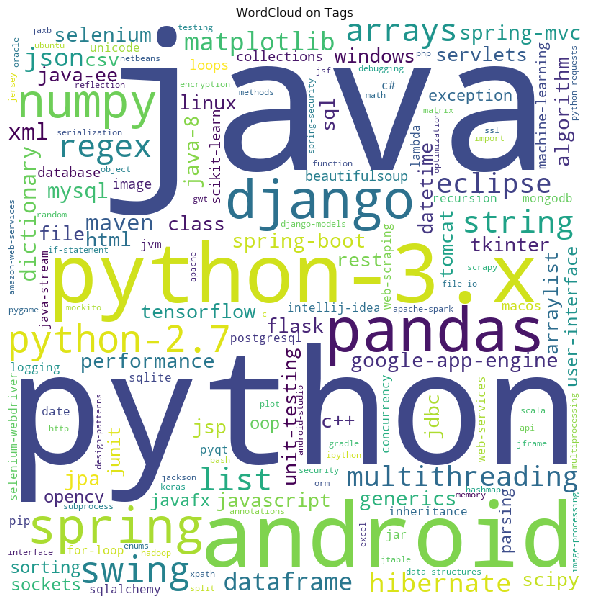

In [0]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(tags_frequency)#(' '.join([' '.join(tag) for tag in tags]))
# plot the WordCloud image     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("WordCloud on Tags")  
plt.show() 


<p>as we can see tags like python,java,android,pandas are very frequent tags</p>

<h2>Top 20 tags<h2>

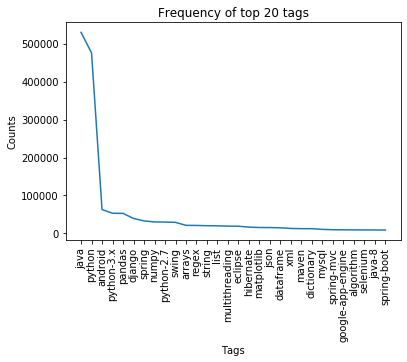

In [0]:
sort_tags_frequency = sorted(list(tags_frequency.items()),key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_tags_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 20 tags")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_tags_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

Max number of tags in question 6
Min number of tags in question 1
Mean number of tags in question 3.3225520092159653


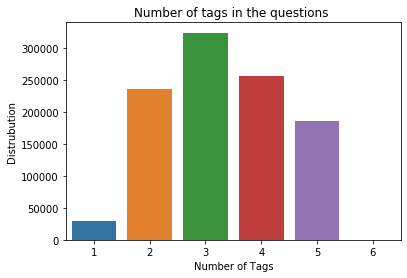

In [0]:
print("Max number of tags in question",max(num_of_tags_in_ques))
print("Min number of tags in question",min(num_of_tags_in_ques))
print("Mean number of tags in question",np.mean(num_of_tags_in_ques))
sns.countplot(num_of_tags_in_ques)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Distrubution")
plt.show()

<h2>3.3 Fitering Tags bases on frequency<h2>

<p>in the dataset we have 25,344 unique tags,so we will be filtering these tags based on frequency due to resource constraints and to better results</p>

5 most frequent tags covers 15.80% points
10 most frequent tags covers 30.13% points
20 most frequent tags covers 42.21% points
50 most frequent tags covers 57.77% points
70 most frequent tags covers 63.56% points
100 most frequent tags covers 69.41% points
200 most frequent tags covers 78.96% points
500 most frequent tags covers 87.87% points
750 most frequent tags covers 90.54% points
1000 most frequent tags covers 92.17% points
2000 most frequent tags covers 94.82% points
3000 most frequent tags covers 95.83% points
5000 most frequent tags covers 96.60% points


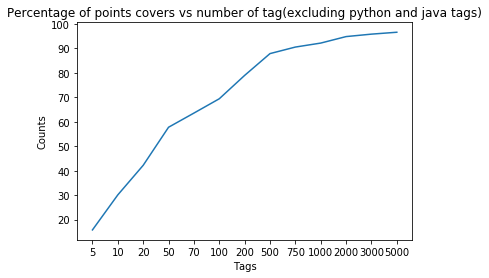

In [0]:
def getPercentageOfDataCoversGivenNumTags(n_tags,tDict,df):
    n_common_tags = heapq.nlargest(n_tags, tags_frequency, key=tags_frequency.get)
    count = 0
    for _rTag in df['tags'].values:
        for _tag in _rTag.split('|'):
            if _tag in ['python','java']:
                continue
            if(_tag in n_common_tags):
                count += 1
                break

    return (count/len(df))*100
    
n_tags = [5,10,20,50,70,100,200,500,750,1000,2000,3000,5000]
percentage_cover = []
for i in n_tags:
    temp = getPercentageOfDataCoversGivenNumTags(i,tags_frequency,data_agg_process)
    percentage_cover.append(temp)
    print("{} most frequent tags covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of tag(excluding python and java tags)")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,n_tags)
plt.show()

<p>As we can see,with 750 tags we are able to cover 90% of the data.so we will be taking only most common 500 tags(due to resource constraints and to better results) and we will be deleting records which has empty tags after filtering the tags.</p>

**And these top 750 tags we are not considering JAVA and PYTHON beacause we filtered using these topics only, if we include those also then only two tags covers all the data points**

In [0]:
common_tags = heapq.nlargest(750, tags_frequency, key=tags_frequency.get)
data_agg_process['tags'] = data_agg_process['tags'].apply(lambda x: [_tag for _tag in x.split('|') if _tag in common_tags])

#removing question which has empty tags
data_agg_process = data_agg_process[data_agg_process['tags'].apply(lambda x: len(x)>1)]

<h2>3.4 Plot on Tags after Filtering</h2>

Max number of tags in question 5
Min number of tags in question 2
Mean number of tags in question 2.895513620519


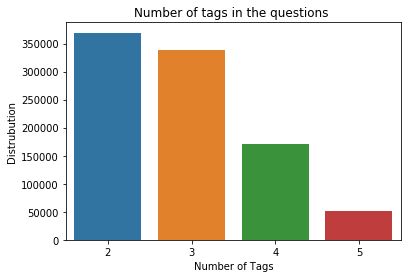

In [0]:
num_of_tags_in_ques_afterFiletringTags = data_agg_process['tags'].apply(lambda x: len(x))
print("Max number of tags in question",max(num_of_tags_in_ques_afterFiletringTags))
print("Min number of tags in question",min(num_of_tags_in_ques_afterFiletringTags))
print("Mean number of tags in question",np.mean(num_of_tags_in_ques_afterFiletringTags))
sns.countplot(num_of_tags_in_ques_afterFiletringTags)
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Distrubution")
plt.show()

In [0]:
data_agg_process['tags'] = data_agg_process['tags'].apply(lambda x: '|'.join(x)) 

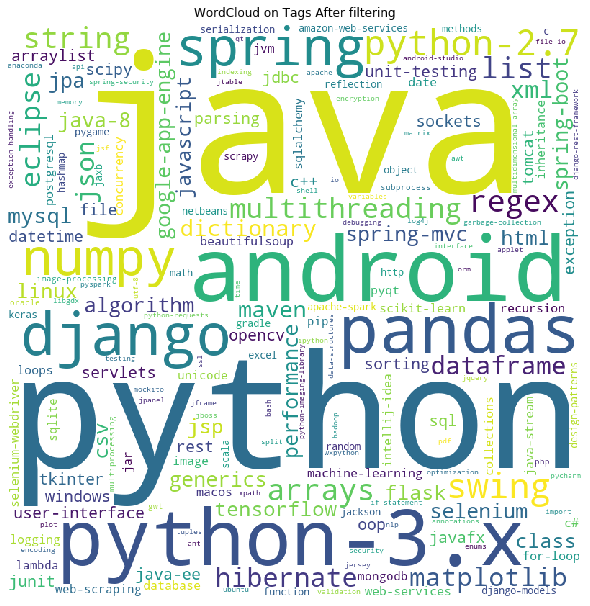

In [0]:
tags_frequency_afterFiltering = {}
num_of_tags_in_ques = []

for _rTag in tags:
    tagsList = _rTag
    for _tag in tagsList:
        if(tags_frequency_afterFiltering.get(_tag,-1)>0):
            tags_frequency_afterFiltering[_tag] += 1
        else:
            tags_frequency_afterFiltering[_tag] = 1

#https://www.geeksforgeeks.org/generating-word-cloud-python/
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate_from_frequencies(tags_frequency_afterFiltering)
                #(' '.join(tag.replace('|',' ') for tag in data_agg_process['tags'].values))
# plot the WordCloud image     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("WordCloud on Tags After filtering")    
plt.show() 

<p>after filtering tags python,java,android,pandas are very frequent tags</p>

<h2>3.5 Saving processed data<h2>

In [0]:
data_agg_process.to_csv(dataDirectory + 'finalProcessed_data.csv',encoding='utf-8',index=False)

#<h1>4. Splitting data to train and test</h1>

In [0]:
from sklearn.model_selection import train_test_split

data = pd.read_csv(dataDirectory + 'finalProcessed_data.csv')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

X_train.to_csv(dataDirectory + 'train_data.csv',encoding='utf-8',index=False)
X_val.to_csv(dataDirectory + 'test_data.csv',encoding='utf-8',index=False)

In [0]:
drive.flush_and_unmount()